<a href="https://colab.research.google.com/github/sebastiangrisalesm-collab/Entregas_IA/blob/main/04_modelo_con_One_Hot_y_SVM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

 📚***Importación de librerías:***

In [ ]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.impute import SimpleImputer
from google.colab import files

🌐***Descarga de los datos desde Kaggle*** :

In [ ]:

files.upload()
os.environ['KAGGLE_CONFIG_DIR'] = '.'
!chmod 600 ./kaggle.json
# Descargar los datos de la competencia #
!kaggle competitions download -c udea-ai-4-eng-20252-pruebas-saber-pro-colombia
!unzip udea-ai-4-eng-20252-pruebas-saber-pro-colombia.zip

Saving kaggle.json to kaggle.json
  0% 0.00/29.9M [00:00<?, ?B/s]
100% 29.9M/29.9M [00:00<00:00, 806MB/s]
Archive:  udea-ai-4-eng-20252-pruebas-saber-pro-colombia.zip
  inflating: submission_example.csv  
  inflating: test.csv                
  inflating: train.csv               


In [ ]:
df = pd.read_csv("train.csv")

In [ ]:
# Tamaño del dataset #
print("El tamaño del dataset es:", df.shape)
df.info()

El tamaño del dataset es: (692500, 21)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 692500 entries, 0 to 692499
Data columns (total 21 columns):
 #   Column                       Non-Null Count   Dtype  
---  ------                       --------------   -----  
 0   ID                           692500 non-null  int64  
 1   PERIODO_ACADEMICO            692500 non-null  int64  
 2   E_PRGM_ACADEMICO             692500 non-null  object 
 3   E_PRGM_DEPARTAMENTO          692500 non-null  object 
 4   E_VALORMATRICULAUNIVERSIDAD  686213 non-null  object 
 5   E_HORASSEMANATRABAJA         661643 non-null  object 
 6   F_ESTRATOVIVIENDA            660363 non-null  object 
 7   F_TIENEINTERNET              665871 non-null  object 
 8   F_EDUCACIONPADRE             669322 non-null  object 
 9   F_TIENELAVADORA              652727 non-null  object 
 10  F_TIENEAUTOMOVIL             648877 non-null  object 
 11  E_PRIVADO_LIBERTAD           692500 non-null  object 
 12  E_PAGOMATRICULAPROP

🤔***Análisis de valores faltantes*** :

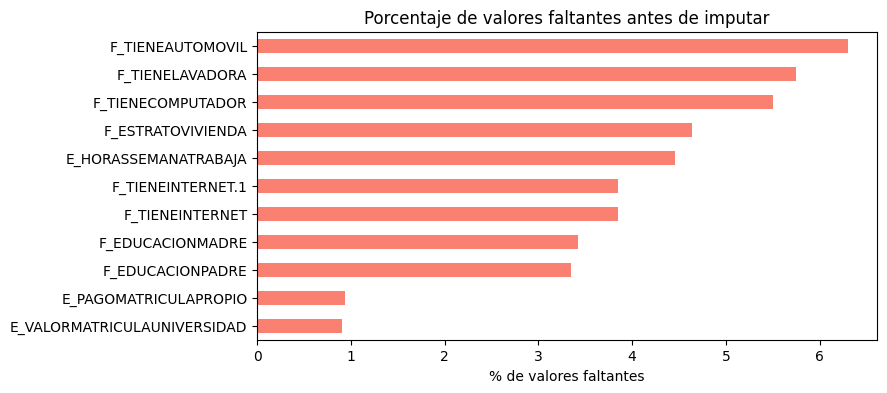

In [ ]:
faltantes_antes = df.isna().mean() * 100
plt.figure(figsize=(8,4))
faltantes_antes[faltantes_antes > 0].sort_values(ascending=False).plot(kind='barh', color='salmon')
plt.title("Porcentaje de valores faltantes antes de imputar")
plt.xlabel("% de valores faltantes")
plt.gca().invert_yaxis()
plt.show()

❌***Estado del dataset antes de imputar*** :

In [ ]:
df_raw = df.copy()
# Antes de la imputación
print("Valores faltantes por cada columna:")
display(df_raw.isna().sum().sort_values(ascending=False).head(21))

Valores faltantes por cada columna:


,0
F_TIENEAUTOMOVIL,43623
F_TIENELAVADORA,39773
F_TIENECOMPUTADOR,38103
F_ESTRATOVIVIENDA,32137
E_HORASSEMANATRABAJA,30857
F_TIENEINTERNET.1,26629
F_TIENEINTERNET,26629
F_EDUCACIONMADRE,23664
F_EDUCACIONPADRE,23178
E_PAGOMATRICULAPROPIO,6498


🧐***Imputación de valores faltantes:***

In [ ]:
# Detectar columnas por tipo #
num_cols = df.select_dtypes(include=['float64', 'int64']).columns
cat_cols = df.select_dtypes(include=['object']).columns

# Las numéricas las imputamos con mediana #
from sklearn.impute import SimpleImputer
num_imputer = SimpleImputer(strategy='median')
df[num_cols] = num_imputer.fit_transform(df[num_cols])

# Las categóricas las imputamos con moda o "missing" #
for col in cat_cols:
    if df[col].isna().mean() > 0.1:
        df[col] = df[col].fillna("missing")
    else:
        df[col] = df[col].fillna(df[col].mode()[0])

print("Imputación de valores completada correctamente.")

Imputación de valores completada correctamente.


✅***Estado del dataset después de imputar:***


Después de la imputación:
Muestra de 10 columnas


,0
ID,0
PERIODO_ACADEMICO,0
E_PRGM_ACADEMICO,0
E_PRGM_DEPARTAMENTO,0
E_VALORMATRICULAUNIVERSIDAD,0
E_HORASSEMANATRABAJA,0
F_ESTRATOVIVIENDA,0
F_TIENEINTERNET,0
F_EDUCACIONPADRE,0
F_TIENELAVADORA,0


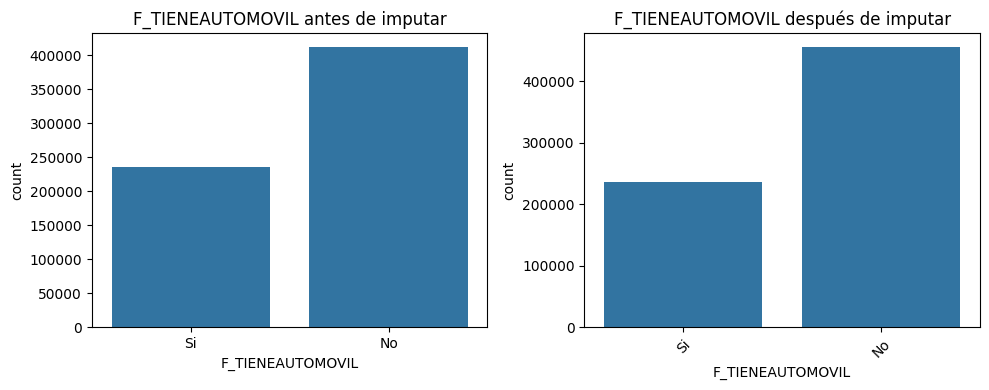

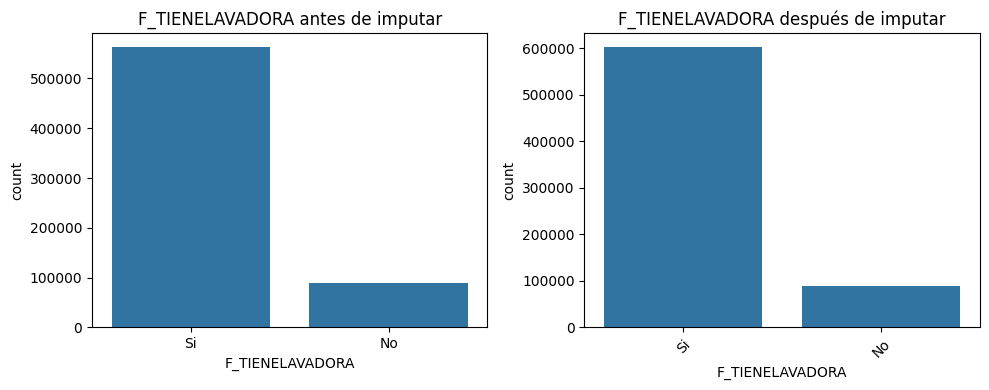

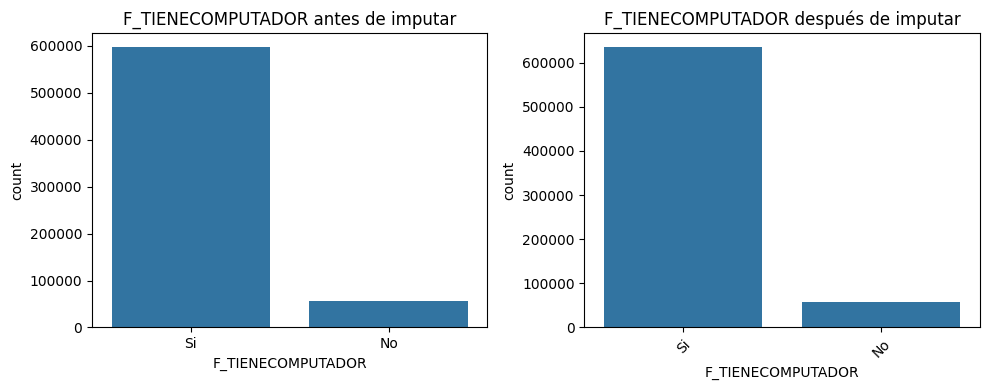

In [ ]:
# Después de la imputación #
print("\nDespués de la imputación:")
print("Muestra de 10 columnas")
display(df.isna().sum().sort_values(ascending=False).head(10))

# Visualización variables categóricas #

import seaborn as sns

cat_cols_a_revisar = ['F_TIENEAUTOMOVIL', 'F_TIENELAVADORA', 'F_TIENECOMPUTADOR']

for col in cat_cols_a_revisar:
    fig, axes = plt.subplots(1, 2, figsize=(10,4))
    sns.countplot(x=df_raw[col], ax=axes[0])
    axes[0].set_title(f'{col} antes de imputar')
    sns.countplot(x=df[col], ax=axes[1])
    axes[1].set_title(f'{col} después de imputar')
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

🔢***Codificación One-Hot:***

In [ ]:
# Seleccionar columnas categóricas con pocas categorías #
cat_cols_limpias = [col for col in cat_cols if df[col].nunique() <= 10]

df_codificado = pd.get_dummies(df, columns=cat_cols_limpias, drop_first=True)

print("Codificación One-Hot completada. Las nuevas dimensiones del dataset son:", df_codificado.shape)

Codificación One-Hot completada. Las nuevas dimensiones del dataset son: (692500, 37)


In [ ]:
from sklearn.preprocessing import LabelEncoder

# Crear la variable objetivo (y)

# para obtener la columna objetivo original.

# Mapeamos las 4 clases de texto a números (0, 1, 2, 3)
# Esto es necesario para que los modelos de Scikit-learn funcionen.
target_map = {
    'bajo': 0,
    'medio-bajo': 1,
    'medio-alto': 2,
    'alto': 3
}
y = df['RENDIMIENTO_GLOBAL'].map(target_map)


# rear las características (X)

# Identificar las columnas objetivo que se crearon (ej. 'RENDIMIENTO_GLOBAL_bajo', etc.)
target_ohe_cols = [col for col in df_codificado.columns if 'RENDIMIENTO_GLOBAL_' in col]

# Identificar la columna duplicada de internet
duplicate_cols = ['F_TIENEINTERNET.1_Si']

# Columnas a eliminar de las características
cols_to_drop = ['ID'] + target_ohe_cols + duplicate_cols

# X son todas las columnas excepto las que eliminamos
X = df_codificado.drop(columns=cols_to_drop)

# --- Verificar los resultados ---
print(f"Forma de X (características): {X.shape}")
print(f"Forma de y (objetivo): {y.shape}")

print("\n--- Objetivo (y) ---")
print(y.head())

print("\n--- Características (X) ---")
print(X.info())

Forma de X (características): (692500, 32)
Forma de y (objetivo): (692500,)

--- Objetivo (y) ---
0    2
1    0
2    0
3    3
4    1
Name: RENDIMIENTO_GLOBAL, dtype: int64

--- Características (X) ---
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 692500 entries, 0 to 692499
Data columns (total 32 columns):
 #   Column                                                                Non-Null Count   Dtype  
---  ------                                                                --------------   -----  
 0   PERIODO_ACADEMICO                                                     692500 non-null  float64
 1   E_PRGM_ACADEMICO                                                      692500 non-null  object 
 2   E_PRGM_DEPARTAMENTO                                                   692500 non-null  object 
 3   F_EDUCACIONPADRE                                                      692500 non-null  object 
 4   F_EDUCACIONMADRE                                                      692500 non-nu

In [ ]:
!pip install category_encoders
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.svm import SVC
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.metrics import accuracy_score
from category_encoders import TargetEncoder

# Definir X e y -

# Mapeo de la variable objetivo
target_map = {'bajo': 0, 'medio-bajo': 1, 'medio-alto': 2, 'alto': 3}
# Usamos 'df' (imputado de la celda 16) para 'y'
y = df['RENDIMIENTO_GLOBAL'].map(target_map)

# Usamos df_codificado para 'X'
target_ohe_cols = [col for col in df_codificado.columns if 'RENDIMIENTO_GLOBAL_' in col]
duplicate_cols = ['F_TIENEINTERNET.1_Si']
cols_to_drop = ['ID'] + target_ohe_cols + duplicate_cols
X = df_codificado.drop(columns=cols_to_drop)


# Identificar Tipos de Columnas en X
high_card_cols = X.select_dtypes(include=['object']).columns.tolist()
num_cols = df.select_dtypes(include=['float64', 'int64']).drop(columns=['ID', 'PERIODO_ACADEMICO']).columns.tolist()
ohe_cols = X.select_dtypes(include=['bool']).columns.tolist()


# Definir el Preprocesador
numeric_transformer = Pipeline(steps=[
    ('scaler', StandardScaler())
])
categorical_transformer = Pipeline(steps=[
    ('target_encoder', TargetEncoder(handle_missing='value', handle_unknown='value'))
])
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, num_cols),
        ('cat', categorical_transformer, high_card_cols),
        ('ohe', 'passthrough', ohe_cols)
    ],
    remainder='drop'
)

# Dividir los datos
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Tomamos una muestra de 20,000 puntos para entrenar el SVM

print("Tomando una muestra de 20,000 puntos para el entrenamiento de SVM...")
sample_size = 20000
indices = np.random.choice(X_train.index, sample_size, replace=False)
X_train_sample = X_train.loc[indices]
y_train_sample = y_train.loc[indices]


# Crear y Entrenar el Pipeline de SVM
model_svm = SVC(random_state=42)
main_pipeline_svm = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', model_svm)
])

print(f"\nEntrenando modelo SVC (SVM) en la muestra de {sample_size} puntos...")

# Entrenar el pipeline en la muestra
main_pipeline_svm.fit(X_train_sample, y_train_sample)

# Evaluar en el conjunto de prueba
y_pred_svm = main_pipeline_svm.predict(X_test)
acc_svm = accuracy_score(y_test, y_pred_svm)

print(f"\n--- ¡Entrenamiento de SVM completado! ---")
print(f"La precisión (Accuracy) del modelo SVM en los datos de prueba es: {acc_svm*100:.2f}%")

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 85.9/85.9 kB 2.7 MB/s eta 0:00:00
Tomando una muestra de 20,000 puntos para el entrenamiento de SVM...

Entrenando modelo SVC (SVM) en la muestra de 20000 puntos...

--- ¡Entrenamiento de SVM completado! ---
La precisión (Accuracy) del modelo SVM en los datos de prueba es: 40.47%
